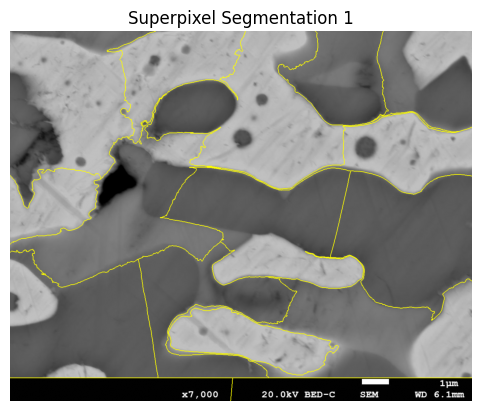

In [32]:
import cv2
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
# Load the image
image = cv2.imread('/Users/maniksinghsarmaal/Downloads/GitHub/Microstructure-Segmentation/test_images/3.jpg') # Your image loading code

# Perform SLIC superpixel segmentation
superpixels = slic(image, n_segments=20, compactness=10)
# Overlay superpixel boundaries on the original image
segmented_image1 = mark_boundaries(image, superpixels)


# Display the superpixel segmented image
plt.imshow(segmented_image1)
plt.title('Superpixel Segmentation 1')
plt.axis('off')
plt.show()



# Adaptive Superpixel Segmentation without num_segments


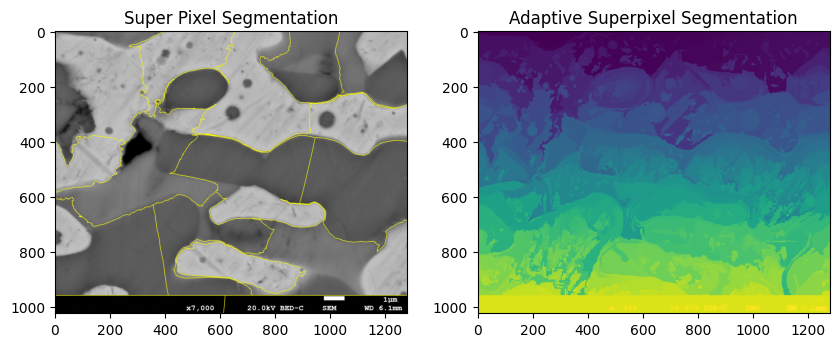

In [41]:
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray
from skimage import io

# Load the image
image = io.imread('/Users/maniksinghsarmaal/Downloads/GitHub/Microstructure-Segmentation/test_images/3.jpg')

# Convert the image to grayscale
image_gray = rgb2gray(image)

# Perform adaptive superpixel segmentation using Felzenszwalb's algorithm
segments_fz = felzenszwalb(image_gray, scale=100, sigma=0.5, min_size=50)

# Visualize the segmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(segmented_image1)
plt.title('Super Pixel Segmentation')

plt.subplot(1, 2, 2)
plt.imshow(segments_fz, cmap='viridis')
plt.title('Adaptive Superpixel Segmentation')

plt.show()


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.datasets import ImageFolder
from skimage.segmentation import slic
import numpy as np
from PIL import Image
import os

class SegmentationCNN(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.conv5(x)
        return x


class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir,target_size=(224, 224)):
        self.image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convert to RGB
        image = self.transform(image)
        return image

# Load the dataset
image_dataset = ImageDataset('/Users/maniksinghsarmaal/Downloads/Eutectic:Non-eutectic/Dataset/train/Eutectic')

# Create the data loader
batch_size = 32
train_loader = DataLoader(image_dataset, batch_size=batch_size, shuffle=True)

# Initialize the CNN model
model = SegmentationCNN(num_classes=300)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images in train_loader:
        for image in images:
            # Superpixel segmentation
            image_np = image.numpy().transpose((1, 2, 0)) * 255  # Convert to numpy format and scale to 0-255
            superpixels = slic(image_np, n_segments=200, compactness=10)

            # Convert superpixels to PyTorch tensor
            superpixels = torch.from_numpy(superpixels).unsqueeze(0).float()

            # Forward pass
            outputs = model(superpixels.unsqueeze(0))

            # Generate pseudo labels from superpixels
            pseudo_labels = superpixels.long()

            # Compute the loss
            loss = criterion(outputs, pseudo_labels)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Print loss for monitoring
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/10], Loss: 5.7237
Epoch [1/10], Loss: 19.3275
Epoch [1/10], Loss: 5.8599
Epoch [1/10], Loss: 5.6768
Epoch [1/10], Loss: 5.6559
Epoch [1/10], Loss: 5.6035
Epoch [1/10], Loss: 5.6801
Epoch [1/10], Loss: 5.5228
Epoch [1/10], Loss: 5.4845
Epoch [1/10], Loss: 5.6522
Epoch [1/10], Loss: 5.6297
Epoch [1/10], Loss: 5.5736
Epoch [1/10], Loss: 5.5712
Epoch [1/10], Loss: 5.4133
Epoch [1/10], Loss: 5.4095
Epoch [1/10], Loss: 5.4450
Epoch [1/10], Loss: 4.9885
Epoch [1/10], Loss: 5.7263
Epoch [1/10], Loss: 5.4289
Epoch [1/10], Loss: 4.8296
Epoch [1/10], Loss: 4.9403
Epoch [1/10], Loss: 4.9181
Epoch [1/10], Loss: 9.6489
Epoch [1/10], Loss: 5.2751
Epoch [1/10], Loss: 5.5115
Epoch [1/10], Loss: 5.6370
Epoch [1/10], Loss: 5.5006
Epoch [1/10], Loss: 5.3546
Epoch [1/10], Loss: 5.4954
Epoch [1/10], Loss: 5.0302
Epoch [1/10], Loss: 5.1286
Epoch [1/10], Loss: 4.7482
Epoch [1/10], Loss: 18.1308
Epoch [1/10], Loss: 10.1975
Epoch [1/10], Loss: 5.1154
Epoch [1/10], Loss: 4.9773
Epoch [1/10], Loss: 5.490

In [42]:
# Assuming 'model' is your trained model
torch.save(model.state_dict(), 'segmented_superpixel_model.pth')


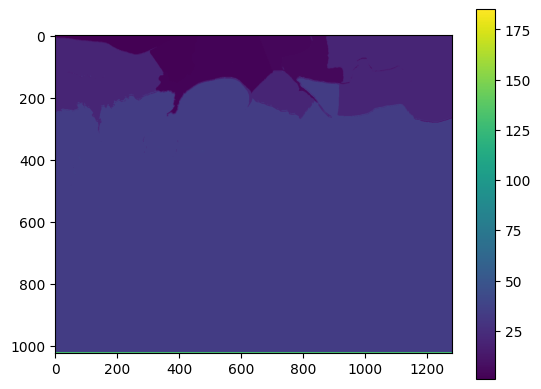

In [46]:
import cv2
from skimage.segmentation import slic
import torch
import numpy as np
import matplotlib.pyplot as plt

# Load the trained model

model.load_state_dict(torch.load('/Users/maniksinghsarmaal/Downloads/GitHub/Microstructure-Segmentation/Adv_models/segmented_superpixel_model.pth'))
model.eval()

# Load and preprocess the test image
test_image = cv2.imread('/Users/maniksinghsarmaal/Downloads/GitHub/Microstructure-Segmentation/test_images/3.jpg')
# Preprocess the image (resize, normalize, etc.)
# preprocess(test_image)

# Perform superpixel segmentation
superpixels = slic(test_image, n_segments=100, compactness=10)

# Convert superpixels to PyTorch tensor
superpixels_tensor = torch.from_numpy(superpixels).unsqueeze(0).float()

# Forward pass through the model
with torch.no_grad():
    outputs = model(superpixels_tensor.unsqueeze(0))

# Generate pseudo labels from superpixels
pseudo_labels = outputs.argmax(dim=1).squeeze().numpy()

# Visualize segmented image
plt.imshow(pseudo_labels)
plt.colorbar()
plt.show()
